In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

In [344]:
DATA_DIR = f'Sleep_dataset.csv'
DF=pd.read_csv(DATA_DIR)
DF['Sleep Disorder'] = DF['Sleep Disorder'].replace(np.nan, 'None')

**Dataset Columns:**
1.   **Person ID**: An identifier for each individual.
2.   **Gender (Male/Female)**: The gender of the person.
3.   **Age**: The age of the person in years.
Occupation: The occupation or profession of the person.
4.   **Sleep Duration (hours)**: The number of hours the person sleeps per day.
5.   **Quality of Sleep (scale: 1-10)**: A subjective rating of the quality of sleep, ranging from 1 to 10.
6.   **Physical Activity Level (minutes/day)**: The number of minutes the person engages in physical activity daily.
7.   **Stress Level (scale: 1-10)**: A subjective rating of the stress level experienced by the person, ranging from 1 to 10.
8.   **BMI Category**: The BMI category of the person (e.g., Underweight, Normal, Overweight).
9.   **Blood Pressure (systolic/diastolic)**: The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.
10.   **Heart Rate (bpm)**: The resting heart rate of the person in beats per minute.
11.  **Daily Steps**: The number of steps the person takes per day.
12.   **Sleep Disorder**: The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).


In [345]:
DF.head() #take a brief look at the data
print(f'The dimention of data is : {DF.shape}')

The dimention of data is : (374, 13)


In [346]:
#taking a look at the data
DF.describe()
DF.nunique()

Person ID                  374
Gender                       2
Age                         31
Occupation                  11
Sleep Duration              27
Quality of Sleep             6
Physical Activity Level     16
Stress Level                 6
BMI Category                 4
Blood Pressure              25
Heart Rate                  19
Daily Steps                 20
Sleep Disorder               3
dtype: int64

## Data Pre-Processing

In [347]:
new_df = DF.copy(deep=True) #Copy done in the next cell
classify_df = DF.copy(deep=True)

### Converting Categorical to Numerical

In [348]:
#Convert String Columns
print(DF['Occupation'].unique())
print(DF['Gender'].unique())
print(DF['Sleep Disorder'].unique())
print(DF['BMI Category'].unique())

occupation_mapping = {
    'Software Engineer':0,
    'Doctor':1,
    'Sales Representative':2,
    'Teacher':3,
    'Nurse':4,
    'Engineer':5,
    'Accountant':6,
    'Scientist':7,
    'Lawyer':8,
    'Salesperson':9,
    'Manager':10
}

gender_mapping = {'Male': 0, 'Female': 1}
sleep_disorder_mapping = {'None': 0, 'Insomnia': 1, 'Sleep Apnea': 2}
bmi_category_mapping = {'Overweight':0, 'Normal':2, 'Obese':3, 'Normal Weight':4}

#blood pressure
def extract_systolic(bp_str):
    try:
        return int(bp_str.split('/')[0])
    except (AttributeError, ValueError, IndexError):
        return np.nan  

def categorize(score):
  if score < 120:
    return 0 #normal
  elif score <= 139:
    return 1 #Prehypertension
  elif score <= 159:
    return 2 #Stage 1 Hypertension
  else:
    return 3 #Stage 2 Hypertension

['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
['Male' 'Female']
['None' 'Sleep Apnea' 'Insomnia']
['Overweight' 'Normal' 'Obese' 'Normal Weight']


In [349]:
classify_df['Occupation'] = classify_df['Occupation'].map(occupation_mapping)
classify_df['Gender'] = classify_df['Gender'].map(gender_mapping)
classify_df['Sleep Disorder'] = classify_df['Sleep Disorder'].map(sleep_disorder_mapping)
classify_df['BMI Category'] = classify_df['BMI Category'].map(bmi_category_mapping)


classify_df['Systolic Blood Pressure'] = classify_df['Blood Pressure'].apply(extract_systolic)
classify_df = classify_df.drop('Blood Pressure', axis=1)

# Example
classify_df['Systolic Blood Pressure'] = classify_df['Systolic Blood Pressure'].apply(lambda x: categorize(x))

# PCA Dataset classify
pca_df = classify_df.copy(deep=True)

#isolate target variable for pca dataset
y = pca_df['Sleep Disorder']

# Drop 'Sleep Disorder' from the dataset
pca_df.drop(columns=['Sleep Disorder'],inplace=True)

Train_df = pca_df.copy(deep=True)



## Dimesion Reduction and PCA

### Principal Component Analysis

In [350]:
pca_df = (pca_df - pca_df.mean(axis=0)) / pca_df.std(axis=0) # Standardize

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(pca_df)

# Convert to DataFrame
pca_scores = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Results
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio per Principal Component:")
for i, variance in enumerate(explained_variance):
    print(f"PC{i+1}: {variance:.2%}")
print(f"Total Variance Explained by First 4 PCs: {sum(explained_variance[:4]):.2%}")
print("Cumulative Variance Ratio:", cumulative_variance)
print("Principal Component Scores:\n", pca_scores.head())

Explained Variance Ratio per Principal Component:
PC1: 34.49%
PC2: 23.28%
PC3: 14.74%
PC4: 9.22%
PC5: 7.09%
PC6: 5.30%
PC7: 2.58%
PC8: 1.43%
PC9: 0.88%
PC10: 0.58%
PC11: 0.37%
PC12: 0.04%
Total Variance Explained by First 4 PCs: 81.73%
Cumulative Variance Ratio: [0.34488263 0.57769901 0.72509987 0.81730261 0.88821029 0.94116029
 0.96697315 0.9812808  0.99012643 0.99590541 0.9995667  1.        ]
Principal Component Scores:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.456979 -0.243266 -1.306650 -1.402583 -0.345054 -0.624812 -1.947520   
1 -3.611860  0.129115  1.808284 -0.800921  0.816866 -0.119979  0.412609   
2 -3.608312  0.132018  1.806822 -0.800439  0.815980 -0.119349  0.415394   
3 -5.326475  0.518563 -1.768679 -1.752901 -2.666919  1.214354 -0.235160   
4 -5.322927  0.521465 -1.770140 -1.752419 -2.667804  1.214984 -0.232375   

        PC8       PC9      PC10      PC11      PC12  
0 -0.308554 -0.270871  0.667993 -0.001576 -0.072407  
1  0.103510  0

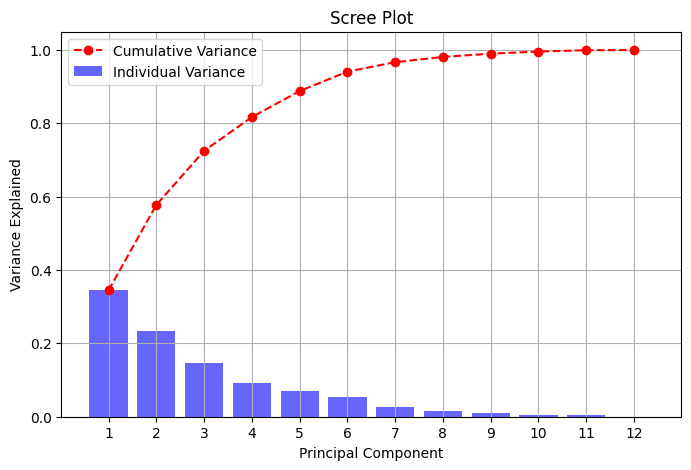

In [351]:
# Get the loadings (eigenvectors)
loadings = pca.components_.T

# Scree Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color="b", label="Individual Variance")
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker="o", linestyle="--", color="r", label="Cumulative Variance")

plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot")
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid()

plt.show()

In [352]:
pca_df.columns

#based on results, remove last 6 components. we can still keep 95% of variance with the first 6 components. 
pca_df = pca_scores.iloc[:,:-6]
print(pca_df.shape)


(374, 6)


### Ordinary Least Squares Regression (OLS)

In [353]:
display(pca_df)
#x is defined previously when we seperated the target variable before we applied PCA
X_array = pca_df.to_numpy() 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)
X = pd.DataFrame(X_scaled, columns=pca_df.columns)
print(y)

,PC1,PC2,PC3,PC4,PC5,PC6
0,-3.456979,-0.243266,-1.306650,-1.402583,-0.345054,-0.624812
1,-3.611860,0.129115,1.808284,-0.800921,0.816866,-0.119979
2,-3.608312,0.132018,1.806822,-0.800439,0.815980,-0.119349
3,-5.326475,0.518563,-1.768679,-1.752901,-2.666919,1.214354
4,-5.322927,0.521465,-1.770140,-1.752419,-2.667804,1.214984
...,...,...,...,...,...,...
369,3.732473,1.626499,0.098830,-0.847168,-0.594956,-0.420968
370,3.689964,1.663143,0.072909,-0.832484,-0.554221,-0.414048
371,3.739569,1.632303,0.095907,-0.846204,-0.596727,-0.419709
372,3.743116,1.635206,0.094445,-0.845722,-0.597613,-0.419079


0      0
1      0
2      0
3      2
4      2
      ..
369    2
370    2
371    2
372    2
373    2
Name: Sleep Disorder, Length: 374, dtype: int64


In [354]:
X = sm.add_constant(X)

# Backward Stepwise Selection Function
def backward_stepwise_selection(X, y, significance_level=0.05):
    features = list(X.columns)  # Get feature names
    
    while len(features) > 1:  
        X_train = X[features] 
        model = sm.OLS(y, X_train).fit()  # Fit OLS model
        
        p_values = model.pvalues.iloc[1:]  # Exclude the intercept
        max_p_value = p_values.max()  # Find highest p-value
        
        if max_p_value > significance_level:
            # Remove the feature with the highest p-value
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print(f"Removed feature: {excluded_feature} (p-value: {max_p_value:.4f})")
        else:
            break  
    
    # Return reduced feature set and final model
    return X[features], model

# Run Backward Stepwise Selection
X_selected, final_model = backward_stepwise_selection(X, y)

print("\nSelected Features (Backward Stepwise Selection):")
print(X_selected.columns.tolist())

# Print Final Model Summary
print("\nFinal Model Summary:")
print(final_model.summary())



Selected Features (Backward Stepwise Selection):
['const', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Sleep Disorder   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     104.0
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           4.86e-76
Time:                        00:07:52   Log-Likelihood:                -264.98
No. Observations:                 374   AIC:                             544.0
Df Residuals:                     367   BIC:                             571.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

## Classification 

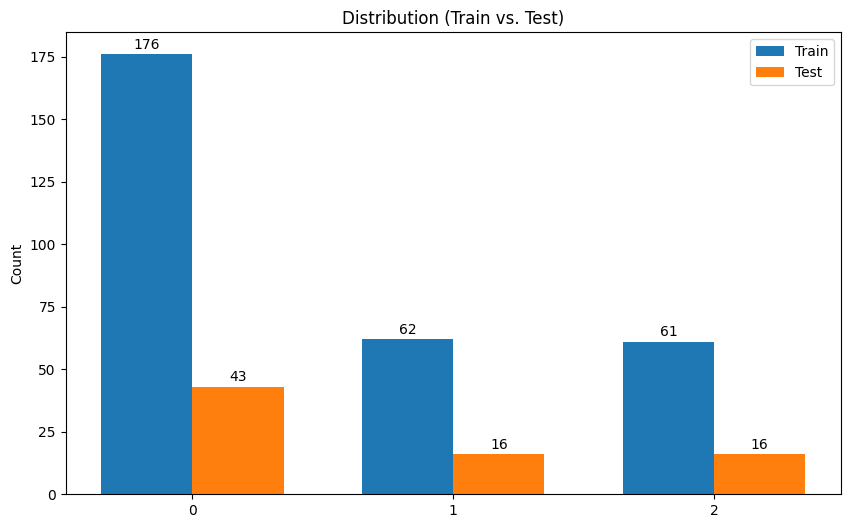

In [355]:
# Split to train_test
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=42)

# Standardized the train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#visual
counts_train = y_train.value_counts()
counts_test = y_test.value_counts()

plt.figure(figsize=(10, 6))
width = 0.35

# Plotting train data
plt.bar(np.arange(len(counts_train)) - width/2, counts_train.values, width, label='Train')

# Plotting test data
plt.bar(np.arange(len(counts_test)) + width/2, counts_test.values, width, label='Test')

plt.ylabel("Count")
plt.title("Distribution (Train vs. Test)")
plt.xticks(np.arange(len(counts_train)))
plt.legend()

# Add labels to the bars
for i, count in enumerate(counts_train.values):
    plt.text(i - width/2, count + 1, str(count), ha='center', va='bottom')
for i, count in enumerate(counts_test.values):
    plt.text(i + width/2, count + 1, str(count), ha='center', va='bottom')

plt.show()

### Logistic Regression

In [356]:
# Train your data using multinomial log regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# 🔹 **Cross-Validation (5-fold)**
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Ensures balanced splits
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

#Evaluate your model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Cross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.8800
Cross-Validation Accuracy (Mean ± Std): 0.8763 ± 0.0225

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.87      0.81      0.84        16
           2       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.87      0.83      0.84        75
weighted avg       0.88      0.88      0.88        75

Confusion Matrix:
 [[42  1  0]
 [ 1 13  2]
 [ 4  1 11]]


c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Jason\AppData\Local\Programs\Python\P

### Random Forest

In [357]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#Cross Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Ensures balanced splits
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Train
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")
print(f"Cross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.8800
Cross-Validation Accuracy (Mean ± Std): 0.8827 ± 0.0361

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        43
           1       0.81      0.81      0.81        16
           2       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.86      0.83      0.84        75
weighted avg       0.88      0.88      0.88        75

Confusion Matrix:
 [[42  1  0]
 [ 1 13  2]
 [ 3  2 11]]


### State Vector Machine

In [358]:
# Initialize SVM Model
svm_model = SVC(kernel='linear', C=1)  # Linear kernel, C=1 (Can be tuned)

cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Ensures balanced splits
cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Train 
svm_model.fit(X_train_scaled, y_train)

# Predict 
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Test Accuracy: {accuracy_svm:.4f}")
print(f"Cross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM Test Accuracy: 0.8800
Cross-Validation Accuracy (Mean ± Std): 0.8795 ± 0.0198

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.87      0.81      0.84        16
           2       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.87      0.83      0.84        75
weighted avg       0.88      0.88      0.88        75

Confusion Matrix:
 [[42  1  0]
 [ 1 13  2]
 [ 4  1 11]]


### K-Nearest Neighbor

In [359]:
# Initialize KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

#CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Ensures balanced splits
cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Train
knn_model.fit(X_train_scaled, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN Test Accuracy: {accuracy_knn:.4f}")
print(f"Cross-Validation Accuracy (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Test Accuracy: 0.8800
Cross-Validation Accuracy (Mean ± Std): 0.8729 ± 0.0172

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        43
           1       0.82      0.88      0.85        16
           2       0.91      0.62      0.74        16

    accuracy                           0.88        75
   macro avg       0.88      0.83      0.84        75
weighted avg       0.88      0.88      0.87        75

Confusion Matrix:
 [[42  1  0]
 [ 1 14  1]
 [ 4  2 10]]


# Recommendation System

## Data Pre-processing

In [360]:
import torch

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert preprocessed NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Convert labels to tensor
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Check tensor shapes
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([299, 6])
X_test_tensor shape: torch.Size([75, 6])
y_train_tensor shape: torch.Size([299])
y_test_tensor shape: torch.Size([75])


### Model

In [361]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np


# Convert data to tensors
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Multiclass labels

# Define Dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Train-test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define Neural Network Model
class SleepDisorderNN(nn.Module):
    def __init__(self, input_dim, num_classes=3, hidden_units=[64, 32], dropout=0.3):
        super(SleepDisorderNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units[0])
        self.fc2 = nn.Linear(hidden_units[0], hidden_units[1])
        self.fc3 = nn.Linear(hidden_units[1], num_classes)  # 3 output classes
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Logits output (before softmax)
        return x

# Initialize Model
input_dim = X_train_scaled.shape[1]  # Number of features
num_classes = 3  # No Sleep Disorder, Sleep Apnea, Insomnia
model = SleepDisorderNN(input_dim, num_classes)

# Define Optimizer & Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Multiclass loss

# Training Loop
def train_model(model, train_loader, val_loader, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        
        val_acc = val_correct / val_total
        print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Train the classifier
train_model(model, train_loader, val_loader)



Epoch [1/30] - Train Acc: 0.6025 | Val Acc: 0.4833
Epoch [2/30] - Train Acc: 0.6109 | Val Acc: 0.4833
Epoch [3/30] - Train Acc: 0.6234 | Val Acc: 0.4833
Epoch [4/30] - Train Acc: 0.6778 | Val Acc: 0.8333
Epoch [5/30] - Train Acc: 0.7824 | Val Acc: 0.9000
Epoch [6/30] - Train Acc: 0.8285 | Val Acc: 0.9000
Epoch [7/30] - Train Acc: 0.8619 | Val Acc: 0.9167
Epoch [8/30] - Train Acc: 0.8703 | Val Acc: 0.9000
Epoch [9/30] - Train Acc: 0.8577 | Val Acc: 0.9167
Epoch [10/30] - Train Acc: 0.8703 | Val Acc: 0.9167
Epoch [11/30] - Train Acc: 0.8870 | Val Acc: 0.9167
Epoch [12/30] - Train Acc: 0.8828 | Val Acc: 0.9167
Epoch [13/30] - Train Acc: 0.8703 | Val Acc: 0.9167
Epoch [14/30] - Train Acc: 0.8912 | Val Acc: 0.9167
Epoch [15/30] - Train Acc: 0.8912 | Val Acc: 0.9167
Epoch [16/30] - Train Acc: 0.8912 | Val Acc: 0.9167
Epoch [17/30] - Train Acc: 0.8828 | Val Acc: 0.9167
Epoch [18/30] - Train Acc: 0.8954 | Val Acc: 0.9167
Epoch [19/30] - Train Acc: 0.8828 | Val Acc: 0.9167
Epoch [20/30] - Train

In [ ]:
import torch
import pandas as pd
from torch.autograd.functional import jacobian

# Modify Function to Recommend Only the Top Feature to Change
def recommend_top_feature_to_improve(model, original_features, feature_names, lr=0.01, steps=100):
    """
    Uses gradient-based optimization to suggest the single most impactful feature to change.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert original features to a PyTorch tensor
    person_features = torch.tensor(original_features, dtype=torch.float32).to(device)
    person_features = person_features.clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([person_features], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        
        # ✅ Convert NumPy array back to a DataFrame to retain feature names
        person_features_df = pd.DataFrame(person_features.cpu().detach().numpy(), columns=feature_names)

        # ✅ Apply PCA transformation while retaining feature names
        person_features_pca = pca.transform(person_features_df)[:, :-6]  # Drop last 6 components
        person_features_pca_tensor = torch.tensor(person_features_pca, dtype=torch.float32, requires_grad=True).to(device)

        # Forward pass
        output = model(person_features_pca_tensor)

        # Compute Jacobian to get gradients manually
        def model_output(inputs):
            return model(inputs)[:, 0]  # Extract probability of "No Sleep Disorder" (Class 0)

        jacob = jacobian(model_output, person_features_pca_tensor)  # Compute gradients

        # Fix: Flatten gradients properly
        gradients = torch.abs(jacob.squeeze()).cpu().numpy()  # Remove extra dimensions
        most_important_feature_idx = gradients.reshape(-1).argmax()  # Ensure correct shape

        # Only update the most important feature, keep others unchanged
        update = torch.zeros_like(person_features)
        update[:, most_important_feature_idx] = torch.tensor(gradients[most_important_feature_idx], dtype=torch.float32).to(device)

        # Apply the single feature update
        person_features.data -= lr * update.data  # Adjust only the most important feature
        
        # Fix: Ensure min/max values match the number of features dynamically
        num_features = person_features.shape[1]
        min_values = torch.full((num_features,), 0, dtype=torch.float32, device=device)  # Set a reasonable minimum (adjust if needed)
        max_values = torch.full((num_features,), 1, dtype=torch.float32, device=device)  # Set a reasonable maximum (adjust if needed)

        # Clip values to ensure realistic feature adjustments
        person_features.data = torch.clamp(person_features.data, min=min_values, max=max_values)

        optimizer.zero_grad()  # Reset gradients

    return most_important_feature_idx, person_features.detach().cpu().numpy()  # Return index and optimized features


# Select an Example Person's Original Features (BEFORE PCA)
new_person_features = Train_df.iloc[0].to_numpy().reshape(1, -1)  # Selects first row as NumPy array and ensures 2D shape

# Get feature names from Train_df
feature_names = Train_df.columns.tolist()

# Get Optimized Feature Recommendations
top_feature_idx, optimized_features = recommend_top_feature_to_improve(model, new_person_features, feature_names)  # Pass original features

# Compare Original vs. Recommended Feature Changes
print(f"Most Important Feature to Change: {feature_names[top_feature_idx]}")
print("Original Features:", new_person_features)
print("Optimized Features (Real-World Feature Space):", optimized_features)




Most Important Feature to Change: Gender
Original Features: [[2.0e+00 0.0e+00 2.8e+01 1.0e+00 6.2e+00 6.0e+00 6.0e+01 8.0e+00 2.0e+00
  7.5e+01 1.0e+04 1.0e+00]]
Optimized Features (Real-World Feature Space): [[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
